Notebook for plotting the final results.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import sem
from matplotlib.patches import Patch

# Predictive Case

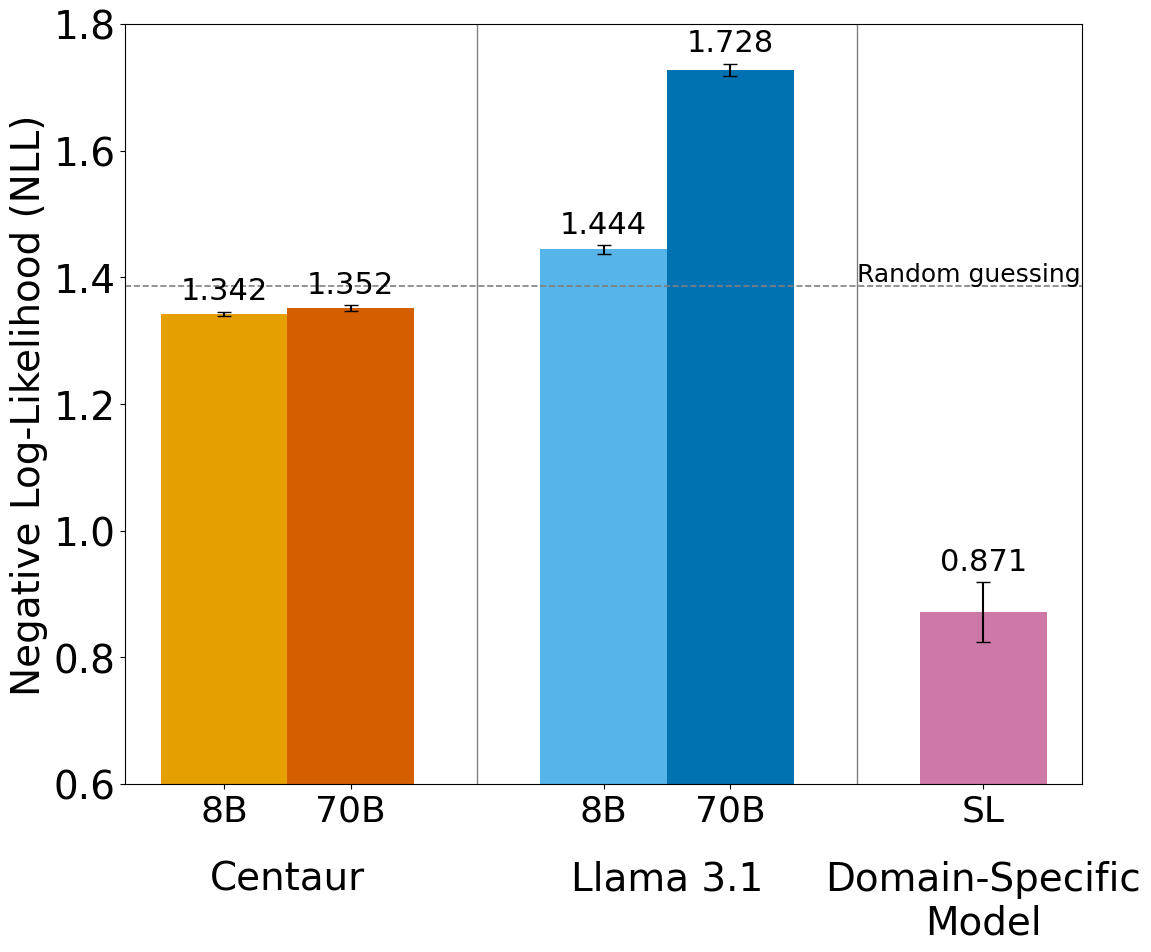

In [2]:
# Load predictive log-likelihood data
centaur_ll = np.load("Data/simulated_data/minitaur_log_likelihoods_predictive.npy", allow_pickle=True)[()]
centaur_big_ll = np.load('Data/simulated_data/centaur_log_likelihoods_predictive.npy', allow_pickle=True)[()]
llama_ll = np.load('Data/simulated_data/llama_8B_log_likelihoods_predictive.npy', allow_pickle=True)[()]
llama_big_ll = np.load('Data/simulated_data/llama_70B_log_likelihoods_predictive.npy', allow_pickle=True)[()]
sl_ll = np.load("Data/simulated_data/SL_model_loglikelihood_predictive.npy", allow_pickle=True)[()]


# ------------------------------------------------------------------
# 0 Grand-mean NLL helper
# ------------------------------------------------------------------
def compute_neg_ll_global(data):
    tot_ll, tot_T, subj_vals = 0.0, 0, []
    for ll in data.values():
        tot_ll += np.sum(ll);  tot_T += len(ll)
        subj_vals.append(-np.mean(ll))
    return -tot_ll / tot_T, sem(subj_vals)

# ------------------------------------------------------------------
# 1 Numbers to plot
# ------------------------------------------------------------------
mu_centaur,  sd_centaur   = compute_neg_ll_global(centaur_ll)
mu_centaurB, sd_centaurB  = compute_neg_ll_global(centaur_big_ll)
mu_llama,    sd_llama     = compute_neg_ll_global(llama_ll)
mu_llamaB,   sd_llamaB    = compute_neg_ll_global(llama_big_ll)
mu_sl,       sd_sl        = compute_neg_ll_global(sl_ll)

means = [mu_centaur, mu_centaurB,
         mu_llama,   mu_llamaB,
         mu_sl]
errs  = [sd_centaur, sd_centaurB,
         sd_llama,   sd_llamaB,
         sd_sl]

# ------------------------------------------------------------------
# 2 Manual x-positions → clustered spacing
# ------------------------------------------------------------------
w        = 0.50     # bar width
gap_in   = 0.00     # gap inside family
gap_out  = 0.50     # gap between families

xpos = [0,                                     # Centaur-8B
        0+w+gap_in,                            # Centaur-70B
        0+2*w+gap_in+gap_out,                  # Llama-8B
        0+3*w+2*gap_in+gap_out,                # Llama-70B
        0+4*w+2*gap_in+2*gap_out]              # SL
xpos = np.array(xpos)

# two-level text helpers
variant_labels = ['8B', '70B', '8B', '70B', 'SL']
family_slices  = [(0,1), (2,3), (4,4)]        # idx ranges for the 3 families
family_labels  = ['Centaur', 'Llama 3.1', 'Domain-Specific\nModel']

# ------------------------------------------------------------------
# 3 Plot
# ------------------------------------------------------------------
# size
plt.rcParams.update({
    'font.size': 22,        # general (titles, labels, ticks, legend)
    'axes.titlesize': 30,   # titles
    'axes.labelsize': 28,   # axis labels
    'xtick.labelsize': 26,  # x-tick labels
    'ytick.labelsize': 28,  # y-tick labels
    'legend.fontsize': 22   # legend text
})

fig, ax = plt.subplots(figsize=(12, 10))

colors = ['#E69F00', '#D55E00', '#56B4E9', '#0072B2','#CC79A7']

# draw bars
bars = ax.bar(xpos, means, w,
              yerr=errs, capsize=5,
              color=colors)


for bar, err, val in zip(bars, errs, means):
    y = bar.get_height()                         # top of the bar
    ax.text(bar.get_x() + bar.get_width()/2,     # x-centre of the bar
            y + err + 0.01,                      # a bit above the error bar
            f'{val:.3f}',                        # value with 2-dec precision
            ha='center', va='bottom',
            fontsize=22)
# ---------------------------------------------------------------

# --- chance level line with inline label --------------------------
chance_nll = -np.log(0.25)          # ≈ 1.386
ax.axhline(chance_nll, ls='--', c='grey', lw=1.2)
ax.text(xpos[-2] + w*1.0,           # position
        chance_nll, 'Random guessing',
        va='bottom', ha='left', fontsize=18)

# ------------------------------------------------------------------
# 4 Two-tier x-axis labelling
# ------------------------------------------------------------------
ax.set_xticks(xpos)
ax.set_xticklabels(variant_labels, ha='center')

for i, family_slice in enumerate(family_slices):
    if isinstance(family_slice, tuple):
        i0, i1 = family_slice
        centre = (xpos[i0] + xpos[i1]) / 2
    else:
        centre = xpos[family_slice]
    ax.text(centre, -0.10, family_labels[i], ha='center', va='top',
            fontsize=28, transform=ax.get_xaxis_transform())


# separate the clusters visually
for i, family_slice in enumerate(family_slices[:-1]):
    if isinstance(family_slice, tuple):
        i0, i1 = family_slice
        ax.axvline(xpos[i1] + w/2 + gap_out/2, color='grey', lw=1)
    else:
         ax.axvline(xpos[family_slice] + w/2 + gap_out/2, color='grey', lw=1)


# ------------------------------------------------------------------
# 5 Plotting the figure
# ------------------------------------------------------------------
ax.set_ylabel('Negative Log-Likelihood (NLL)')

ax.set_ylim(0.6, 1.8)
ax.margins(x=0.04)
plt.tight_layout()

plt.savefig('fig_1E.png', format='png', dpi=600, facecolor='white', edgecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show()

# Generative Case

In [3]:
def set_dynamic_fontsize(fig_width=12, base_font=20):
    scale = fig_width / 6  # 6 is your baseline width, adjust as needed
    plt.rcParams.update({
        'font.size': base_font * scale * 0.65,
        'axes.titlesize': base_font * scale * 1.2,
        'axes.labelsize': base_font * scale * 0.9,
        'xtick.labelsize': base_font * scale * 0.9,
        'ytick.labelsize': base_font * scale * 0.9,
        'legend.fontsize': base_font * scale,
    })

# Example: for a large figure
set_dynamic_fontsize(fig_width=12)

In [4]:
# Load generative metrics data
human_correct = np.load('Data/simulated_data/human_correct_generative.npy', allow_pickle=True)[()]
centaur_correct = np.load('Data/simulated_data/minitaur_correct_generative.npy', allow_pickle=True)[()]
centaur_big_correct = np.load('Data/simulated_data/centaur_correct_generative.npy', allow_pickle=True)[()]
llama_correct = np.load('Data/simulated_data/llama_8B_correct_generative.npy', allow_pickle=True)[()]
llama_big_correct = np.load('Data/simulated_data/llama_70B_correct_generative.npy', allow_pickle=True)[()]
sl_correct = np.load('Data/simulated_data/SL_model_correct_generative.npy', allow_pickle=True)[()]


human_perseverance = np.load("Data/simulated_data/human_perseverance_err.npy", allow_pickle=True)[()]
centaur_perseverance = np.load("Data/simulated_data/minitaur_perseverance_err.npy", allow_pickle=True)[()]
centaur_big_perseverance = np.load('Data/simulated_data/centaur_perseverance_err.npy', allow_pickle=True)[()]
llama_perseverance = np.load('Data/simulated_data/llama_8B_perseverance_err.npy', allow_pickle=True)[()]
llama_big_perseverance = np.load('Data/simulated_data/llama_70B_perseverance_err.npy', allow_pickle=True)[()]
sl_perseverance = np.load("Data/simulated_data/SL_model_persev_generative.npy", allow_pickle=True)[()]


human_setloss = np.load("Data/simulated_data/human_setloss_err.npy", allow_pickle=True)[()]
centaur_setloss = np.load("Data/simulated_data/minitaur_setloss_err.npy", allow_pickle=True)[()]
centaur_big_setloss = np.load('Data/simulated_data/centaur_setloss_err.npy', allow_pickle=True)[()]
llama_setloss = np.load('Data/simulated_data/llama_8B_setloss_err.npy', allow_pickle=True)[()]
llama_big_setloss = np.load('Data/simulated_data/llama_70B_setloss_err.npy', allow_pickle=True)[()]
sl_setloss = np.load("Data/simulated_data/SL_model_setloss_generative.npy", allow_pickle=True)[()]


# ------------------------------------------------------------------
# 0. Subject-mean metrics helper
# ------------------------------------------------------------------
def compute_mean_sem(data):
    avg_per_subject = [np.mean(v) for v in data.values()]
    return np.mean(avg_per_subject), sem(avg_per_subject) if avg_per_subject else (0, 0)

# -------------------------------------------------
# 1. Parameters and numbers to plot
# -------------------------------------------------
metrics = ['Accuracy', 'Perseveration Error', 'Set-Loss Error']
x = np.arange(len(metrics))     # 3 metrics
width           = 0.12          # width of one bar
inter_group_gap = width * 0.15  # “tiny distance” between families


models = ['Human Data', 'Centaur-8B', 'Centaur-70B', 'Llama-3.1-8B', 'Llama-3.1-70B', 'Domain-Specific Model']
colors = ['#44403b', '#E69F00', '#D55E00', '#56B4E9', '#0072B2','#CC79A7']


# Get means and stds for each metric by model
accuracy = [compute_mean_sem(d) for d in [human_correct, centaur_correct, centaur_big_correct, llama_correct, llama_big_correct, sl_correct]]
perseveration = [compute_mean_sem(d) for d in [human_perseverance, centaur_perseverance, centaur_big_perseverance, llama_perseverance, llama_big_perseverance, sl_perseverance]]
setloss = [compute_mean_sem(d) for d in [human_setloss, centaur_setloss, centaur_big_setloss, llama_setloss, llama_big_setloss, sl_setloss]]

# Each entry = number of bars in that family, left-to-right
group_sizes = [1,       # Human
               2,       # Centaur-8B, Centaur-70B
               2,       # Llama-8B,  Llama-70B
               1]       # SL
# -------------------------------------------------
# 2. Build a list of horizontal offsets
# -------------------------------------------------
offsets = []
cursor  = 0.0
for g in group_sizes:
    for _ in range(g):           # bars inside the family
        offsets.append(cursor)
        cursor += width
    cursor += inter_group_gap    # jump to the next family

cursor -= inter_group_gap        # drop the extra gap after the last family

# Centre the whole stripe of 7 bars on x
centre = (offsets[0] + offsets[-1]) / 2
offsets = [o - centre for o in offsets]


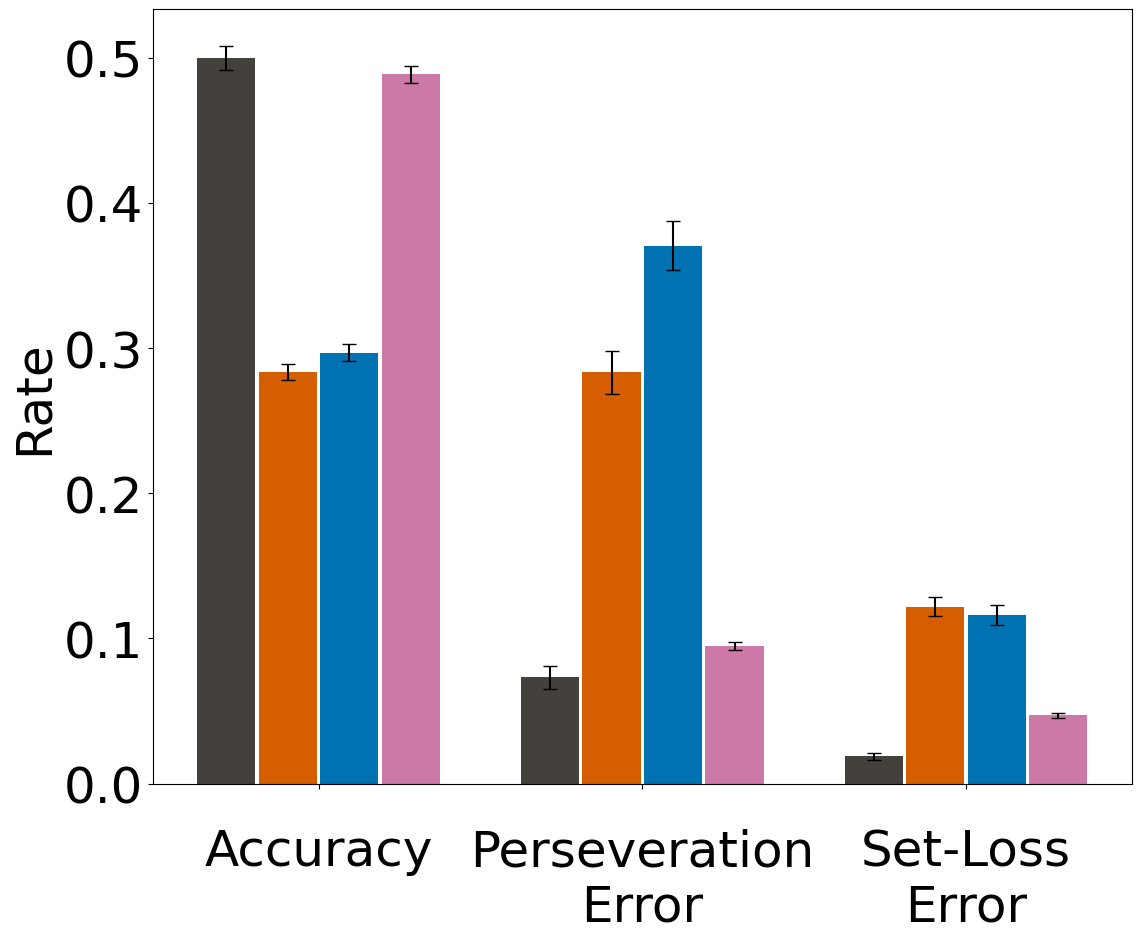

In [5]:
# -------------------------------------------------
# 3. Use offsets when you draw the bars
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 10))
metrics_updated = ['Accuracy', 'Perseveration\nError', 'Set-Loss\nError']

# Filter only the models we want: Human Data, Centaur-70B, Llama-3.1-70B, Domain-Specific Model
selected_indices = [0, 2, 4, 5]  # Indices for Human, Centaur-70B, Llama-3.1-70B, SL
selected_models = [models[i] for i in selected_indices]
selected_colors = [colors[i] for i in selected_indices]

# Recalculate offsets for 4 models with gaps between bars
width = 0.18         # Keep your current bar width
gap = 0.01         # Add explicit gap between bars
total_width = width * 4 + gap * 3  # Total width of all bars + gaps
start = -total_width / 2 + width/2  # Start position to center the group

# Calculate offsets with gaps
offsets = []
for i in range(4):
    offsets.append(start + i * (width + gap))

for i, (model_idx, model, color) in enumerate(zip(selected_indices, selected_models, selected_colors)):
    means = [accuracy[model_idx][0], perseveration[model_idx][0], setloss[model_idx][0]]
    stds  = [accuracy[model_idx][1], perseveration[model_idx][1], setloss[model_idx][1]]

    ax.bar(x + offsets[i], means,
           width, yerr=stds, capsize=5,
           label=model, color=color)

# ------------------------------------------------------------------
# 5. Plotting the figure
# ------------------------------------------------------------------
ax.set_xticks(x)
ax.set_xticklabels(metrics_updated)

# ── add a little vertical gap between the tick labels and the axis
ax.tick_params(axis='x', which='major', pad=28)   # ← tweak "12" to taste


ax.set_ylabel('Rate')
plt.tight_layout()

plt.savefig('fig_1F.png', format='png', dpi=600, facecolor='white', edgecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show()

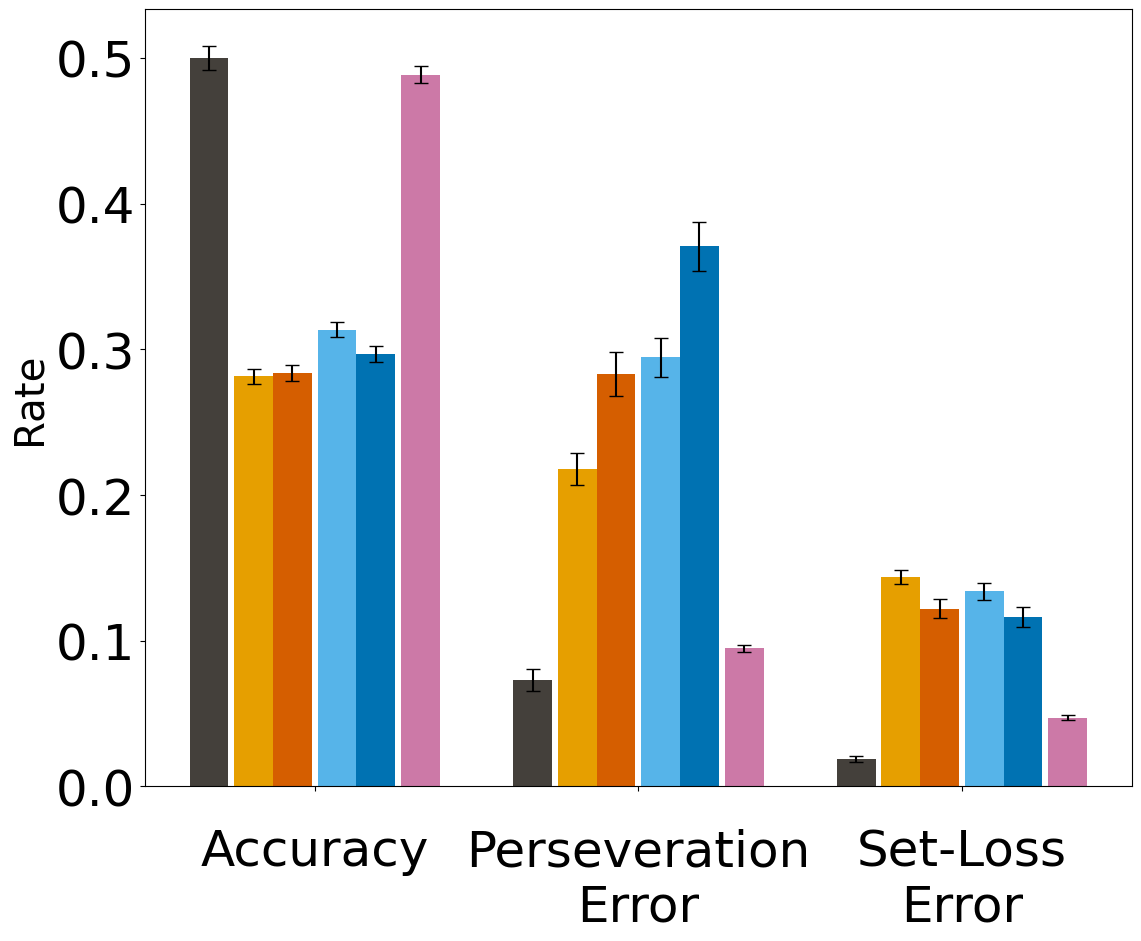

In [6]:
# -------------------------------------------------
# 1. Parameters and numbers to plot
# -------------------------------------------------
metrics = ['Accuracy', 'Perseveration\nError', 'Set-Loss\nError']
x = np.arange(len(metrics))     # 3 metrics
width           = 0.12          # width of one bar
inter_group_gap = width * 0.15  # “tiny distance” between families


models = ['Human Data', 'Centaur-8B', 'Centaur-70B', 'Llama-3.1-8B', 'Llama-3.1-70B', 'Domain-Specific Model']
colors = ['#44403b', '#E69F00', '#D55E00', '#56B4E9', '#0072B2','#CC79A7']


# Get means and stds for each metric by model
accuracy = [compute_mean_sem(d) for d in [human_correct, centaur_correct, centaur_big_correct, llama_correct, llama_big_correct, sl_correct]]
perseveration = [compute_mean_sem(d) for d in [human_perseverance, centaur_perseverance, centaur_big_perseverance, llama_perseverance, llama_big_perseverance, sl_perseverance]]
setloss = [compute_mean_sem(d) for d in [human_setloss, centaur_setloss, centaur_big_setloss, llama_setloss, llama_big_setloss, sl_setloss]]

# Each entry = number of bars in that family, left-to-right
group_sizes = [1,       # Human
               2,       # Centaur-8B, Centaur-70B
               2,       # Llama-8B,  Llama-70B
               1]       # SL
# -------------------------------------------------
# 2. Build a list of horizontal offsets
# -------------------------------------------------
offsets = []
cursor  = 0.0
for g in group_sizes:
    for _ in range(g):           # bars *inside* the family
        offsets.append(cursor)
        cursor += width
    cursor += inter_group_gap    # jump to the next family

cursor -= inter_group_gap        # drop the extra gap after the last family

# Centre the whole stripe of 7 bars on x
centre = (offsets[0] + offsets[-1]) / 2
offsets = [o - centre for o in offsets]

# -------------------------------------------------
# 3. Use offsets when you draw the bars
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 10))

for i, (model, color) in enumerate(zip(models, colors)):
    means = [accuracy[i][0], perseveration[i][0], setloss[i][0]]
    stds  = [accuracy[i][1], perseveration[i][1], setloss[i][1]]

    ax.bar(x + offsets[i], means,
           width, yerr=stds, capsize=5,
           label=model, color=color)

# ------------------------------------------------------------------
# 5. Plotting the figure
# ------------------------------------------------------------------
ax.set_xticks(x)
ax.set_xticklabels(metrics)

# ── add a little vertical gap between the tick labels and the axis
ax.tick_params(axis='x', which='major', pad=26)   # ← tweak “12” to taste


ax.set_ylabel('Rate', size = 29)
plt.tight_layout()

plt.savefig('fig_1F.png', format='png', dpi=600, facecolor='white', edgecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show()